# Lab 2: Grover's Algorithm

In this lab, you will implement Grover's algorithm in `Qiskit` and investigate its behavior.

You might find this chapter of the Qiskit Textbook useful:
- https://qiskit.org/textbook/ch-algorithms/grover.html

# Review of Grover's Algorithm

You might recall that Grover's algorithm has three main components. 
1. First, we begin by creating a superposition of all $2^n$ computational basis states by applying a Hadamard ($H$) gate on each qubit starting off in the state $\vert0\rangle^{\otimes n}$. Here, the exponent $\otimes n$ means that we have a tensor product of the states of $n$ qubits. 
2. Second, we apply an Oracle operator to mark the appropriate elements among the $2^n$ elements. The oracle operator applies a coefficient of $-1$ to each of the marked elements.
3. Third, we apply a Diffusion operator, or diffuser, which inverts the amplitude of all elements about the average amplitude.

Putting these components together, and applying the Oracle and Diffusion operators $O(\sqrt{N = 2^n})$ times, Grover's algorithm allows us to successfully determine the elements that were marked by the Oracle operator with high probability. This is shown in the block diagram above, where the quantum circuit for Grover's algorithm is depicted with a measurement in the end to read out the qubits.

# Graded Exercise 1: Implementing Grover's Algorithm

As you saw in the lecture, it is not hard to implement Grover's algorithm using `Qiskit`. The goal of this lab is to implement Grover's algorithm by creating a quantum circuit that has the marked elements `000001` and `101010`. You will see that the algorithm outputs one of these two marked elements with probability greater than $99\%$. 

Let us build each block step by step.

### 1.) Phase Oracle
We start with the phase oracle. You might find it helpful to have a look at the corresponding chapter in the Qiskit textbook: https://qiskit.org/textbook/ch-algorithms/grover.html. However, note that the implementation in the textbook is done on 2 and 3 qubits only, while here we need to apply it to 6 qubits.

**Recall that the action of the phase oracle is to add a phase of $-1$ to all states representing the marked elements, while leaving all other states unchanged.** An easy way to implement the phase oracle is to create an identity matrix on all $n$ qubits (remember that the corresponding dimension of this matrix is $2^n$) and then change those diagonal elements to $-1$ that correspond to the marked elements. Then, you need to convert that unitary into an operator.

We have created a function below called `phase_oracle` which takes in two arguments. The first argument, $n$, gives the number of qubits in the quantum circuit. The second argument, `indices_to_mark`, is a list of the indices whose elements will be marked by the phase oracle with a phase of $-1$. Using these inputs, create a $2^n\times2^n$ identity matrix, and apply a phase of $-1$ to the diagonal elements at locations given in `indices_to_mark`. For example, if $0$ is in `indices_to_mark`, that means you need to set the top-left-most diagonal element of the identity matrix to -1.

Once you complete these steps, apply the unitary operator to the quantum circuit.

In [47]:
from qiskit.quantum_info import Operator
from qiskit import QuantumCircuit, Aer, IBMQ, execute

from qiskit.providers.ibmq import least_busy
from qiskit.converters import circuit_to_instruction
import numpy as np

In [48]:
def phase_oracle(n, indices_to_mark, name = 'Oracle'):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name=name)

    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    oracle_matrix = np.eye(2**n)
    oracle_matrix[(indices_to_mark, indices_to_mark)] = -1
    ### WRITE YOUR CODE BETWEEN THESE LINES - END

    # convert your matrix (called oracle_matrix) into an operator, and add it to the quantum circuit
    qc.unitary(Operator(oracle_matrix), range(n))
    
    return qc

### 2.) Diffusion Operator $V$

Next, we define the diffuser, which we called $V$ in the lecture. Its effect is to reflect all amplitudes about the average amplitude. To do so, we simply call the `phase_oracle` with only the zero state ($\vert0\rangle^{\otimes n}$) as the marked element and sandwich it between Hadamard gates applied to all qubits.

In [49]:
def diffuser(n):
    
    # create a quantum circuit on n qubits
    qc = QuantumCircuit(n, name='Diffuser')
    
    ### WRITE YOUR CODE BETWEEN THESE LINES - START
    # for i in range(n):
    qc.h(range(n))
    qc.append(phase_oracle(n, [0]), [range(n)])
    qc.h(range(n))

    ### WRITE YOUR CODE BETWEEN THESE LINES - END
    
    return qc

### 3.) Putting it all together

Finally, we combine the functions to construct Grover's algorithm. We need to determine the optimal number of rounds $r$ as described in the lecture.

This was given by 

$$r = \left\lfloor\frac{\pi}{4}\sqrt{\frac{N}{k}}\right\rfloor$$

where $k$ is the number of marked elements, and $\lfloor~\rfloor$ means rounding down to the nearest integer. In the specific example that we consider here, where we have six qubits ($N = 2^6$) and two marked elements ($k = 2$), implying that $r = 4$. You can check this yourself by plugging in the numbers.

In the lecture, we have also seen a lower bound on the success probability when using $n$ qubits. In this exercise, the success probability should be higher than $99\%$.

Let's construct a quantum program that finds the marked elements `000001` and `101010` using Grover's algorithm. To do this, we will need to do the following: 
1. We start with a Hadamard gate on all qubits.
2. Next, we apply $r$ rounds of Grover's algorithm, where each round consists of the application of the phase oracle with the marked elements and the diffuser. The indices for the two marked elements `000001` and `101010` are $1$ and $42$. 
3. Finally, we need to measure all qubits.

The next lines of code put everything together. **You do not need to modify anything below, but you will need to run the cell to submit your solution.**

In [50]:
def Grover(n, indices_of_marked_elements):
    
    # Create a quantum circuit on n qubits
    qc = QuantumCircuit(n, n)
    
    # Determine r
    r = int(np.floor(np.pi/4*np.sqrt(2**n/len(indices_of_marked_elements))))
    print(f'{n} qubits, basis states {indices_of_marked_elements} marked, {r} rounds')
    
    # step 1: apply Hadamard gates on all qubits
    qc.h(range(n))
    
    # step 2: apply r rounds of the phase oracle and the diffuser
    for _ in range(r):
        qc.append(phase_oracle(n, indices_of_marked_elements), range(n))
        qc.append(diffuser(n), range(n))
        
    # step 3: measure all qubits
    qc.measure(range(n), range(n))
  
    return qc

mycircuit = Grover(6, [1, 42])
mycircuit.draw()

6 qubits, basis states [1, 42] marked, 4 rounds


CircuitError: 'The amount of qubit arguments 1 does not match the instruction expectation (6).'

That's it! You might find it useful to run your quantum circuit and see the measurement outcomes, as well as visualize the statevector at the end.

In order to run your quantum circuit and get the measurement outcomes, you simply need to run `Qiskit`'s `execute` function as follows.

/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:499: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/opt/conda/lib/python3.8/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
<frozen importlib._bootstrap>:219: RuntimeWarning: scipy._lib.messagestream.MessageStream size changed, may indicate binary incompatibility. Expected 56 from C header, got 64 from PyObject


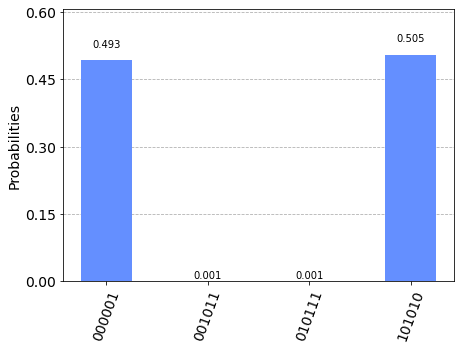

In [6]:
from qiskit import Aer, execute
simulator = Aer.get_backend('qasm_simulator')
counts = execute(mycircuit, backend=simulator, shots=1000).result().get_counts(mycircuit)
from qiskit.visualization import plot_histogram
plot_histogram(counts)

# Run on Real Device

In [13]:
provider = IBMQ.load_account()

In [14]:
n = 3
x = np.random.randint(2**n)
y = np.random.randint(2**n)

while y==x:
    y = np.random.randint(2**n)
    
marked = [x, y]

### WRITE YOUR CODE BETWEEN THESE LINES - START


### WRITE YOUR CODE BETWEEN THESE LINES - END

job = execute(qc, backend=backend, shots=1024, optimization_level=3)

3 qubits, basis states [7, 4] marked, 1 rounds


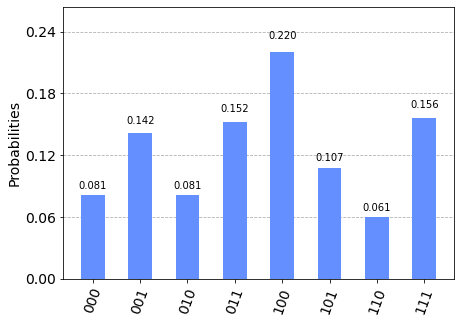

In [15]:
results = job.result()
answer = results.get_counts()
plot_histogram(answer)

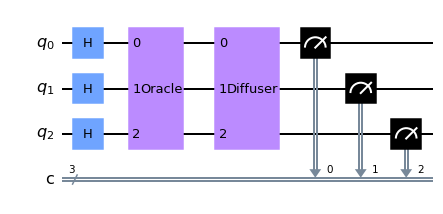

In [18]:
qc.draw()